In [20]:
%pylab inline
% pylab inline
from numpy import linalg as LA
from tqdm import tqdm_notebook
import os
import sklearn.preprocessing as prep
import pickle
import joblib
import tensorflow as tf
import seaborn as sns
sns.set_context('talk', font_scale=2)

def min_max_scale(X):
    preprocessor = prep.MinMaxScaler().fit(X)
    X_scaled = preprocessor.transform(X)
    return X_scaled

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [4]:
master_matrix = joblib.load('../scripts/tumor_and_normal_200000_standardized_X.joblib.pickle')
y = joblib.load('../scripts/tumor_and_normal_200000_standardized_y.joblib.pickle')


In [5]:
WIDTH = 256 
HEIGHT = 256
DEPTH = 3

def standardize_image(f):
    standardized = (imread(f) / 255.0).reshape(-1, 256 * 256 * 3)
    return standardized

In [6]:
config = tf.ConfigProto(
    device_count = {'GPU': 0}
)
config.gpu_options.allocator_type = 'BFC'
#config

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
IMAGE_CHANNELS = 3


class VAE(object):
    def __init__(self,
                 input_dim,
                 learning_rate=0.001,
                 n_latent=100,
                 batch_size=50):
        self.learning_rate = learning_rate
        self.n_latent = n_latent
        self.batch_size = batch_size
        self.input_dim = input_dim

        self._build_network()
        self._create_loss_optimizer()

        init = tf.global_variables_initializer()
        #init = tf.initialize_all_variables()
        # Launch the session
        self.session = tf.InteractiveSession(config=config)
        self.session.run(init)
        self.saver = tf.train.Saver(tf.all_variables())

    def _build_network(self):
        self.x = tf.placeholder(tf.float32, [None, self.input_dim])
        dense1 = tf.layers.dense(
            activation=tf.nn.elu, inputs=self.x, units=512)
        dense2 = tf.layers.dense(
            activation=tf.nn.elu, inputs=dense1, units=512)
        dense3 = tf.layers.dense(
            activation=tf.nn.elu, inputs=dense2, units=512)
        dense4 = tf.layers.dense(
            activation=None, inputs=dense3, units=self.n_latent * 2)
        self.mu = dense4[:, :self.n_latent]
        self.sigma = tf.nn.softplus(dense4[:, self.n_latent:])
        eps = tf.random_normal(
            shape=tf.shape(self.sigma), mean=0, stddev=1, dtype=tf.float32)
        self.z = self.mu + self.sigma * eps

        ddense1 = tf.layers.dense(
            activation=tf.nn.elu, inputs=self.z, units=512)
        ddense2 = tf.layers.dense(
            activation=tf.nn.elu, inputs=ddense1, units=512)
        ddense3 = tf.layers.dense(
            activation=tf.nn.elu, inputs=ddense2, units=512)

        self.reconstructed = tf.layers.dense(
            activation=tf.nn.sigmoid, inputs=ddense3, units=self.input_dim)

    def _create_loss_optimizer(self):
        epsilon = 1e-10
        reconstruction_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon + self.reconstructed) +
            (1 - self.x) * tf.log(epsilon + 1 - self.reconstructed),
            axis=1)

        self.reconstruction_loss = tf.reduce_mean(
            reconstruction_loss) / self.batch_size

        latent_loss = -0.5 * tf.reduce_sum(
            1 + tf.log(epsilon + self.sigma) - tf.square(self.mu) - tf.square(
                self.sigma),
            axis=1)
        latent_loss = tf.reduce_mean(latent_loss) / self.batch_size
        self.latent_loss = latent_loss
        self.cost = tf.reduce_mean(self.reconstruction_loss + self.latent_loss)
        # ADAM optimizer
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.cost)

    def fit_minibatch(self, batch):
        _, cost, reconstruction_loss, latent_loss = self.session.run(
            [
                self.optimizer, self.cost, self.reconstruction_loss,
                self.latent_loss
            ],
            feed_dict={self.x: batch})
        return cost, reconstruction_loss, latent_loss

    def reconstruct(self, x):
        return self.session.run([self.reconstructed], feed_dict={self.x: x})

    def decoder(self, z):
        return self.session.run([self.reconstructed], feed_dict={self.z: z})

    def encoder(self, x):
        return self.session.run([self.z], feed_dict={self.x: x})

    def save_model(self, checkpoint_path, epoch):
        self.saver.save(self.session, checkpoint_path, global_step=epoch)

    def load_model(self, checkpoint_dir):
        #new_saver = tf.train.import_meta_graph(checkpoint_path)
        #new_saver.restore(sess, tf.train.latest_checkpoint('./'))

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir=checkpoint_dir, latest_filename='checkpoint')
        print('loading model: {}'.format(ckpt.model_checkpoint_path))
        self.saver.restore(self.session, ckpt.model_checkpoint_path)
        
    

In [7]:
learning_rate=1e-4
batch_size=32
num_epoch=1000
n_latent=100
    
checkpoint_dir = '/Z/personal-folders/interns/saket/vae_checkpoint_histoapath_2000_nlatent100'   
os.makedirs(checkpoint_dir, exist_ok=True)
input_dim = IMAGE_CHANNELS*IMAGE_WIDTH*IMAGE_HEIGHT
tf.reset_default_graph()
#input_dims = input_dim[1]
model = VAE(input_dim=input_dim,
            learning_rate=learning_rate,
            n_latent=n_latent,
            batch_size=batch_size)
model.load_model(checkpoint_dir)

Instructions for updating:
Please use tf.global_variables instead.
loading model: /Z/personal-folders/interns/saket/vae_checkpoint_histoapath_2000_nlatent100/model.ckpt-995-995
INFO:tensorflow:Restoring parameters from /Z/personal-folders/interns/saket/vae_checkpoint_histoapath_2000_nlatent100/model.ckpt-995-995


In [8]:
x_sample = np.reshape(master_matrix, (-1, 256*256*3))
x_encoded =  model.encoder(x_sample)
x_reconstruct = model.reconstruct(x_sample)
joblib.dump(x_encoded, '../pickles/x_200k_encoded_nlatent100.joblib.pickle')
joblib.dump(x_reconstruct, '../pickles/x_200k_reconstructed_nlatent100.joblib.pickle')


['../pickles/x_200k_reconstructed_nlatent100.joblib.pickle']

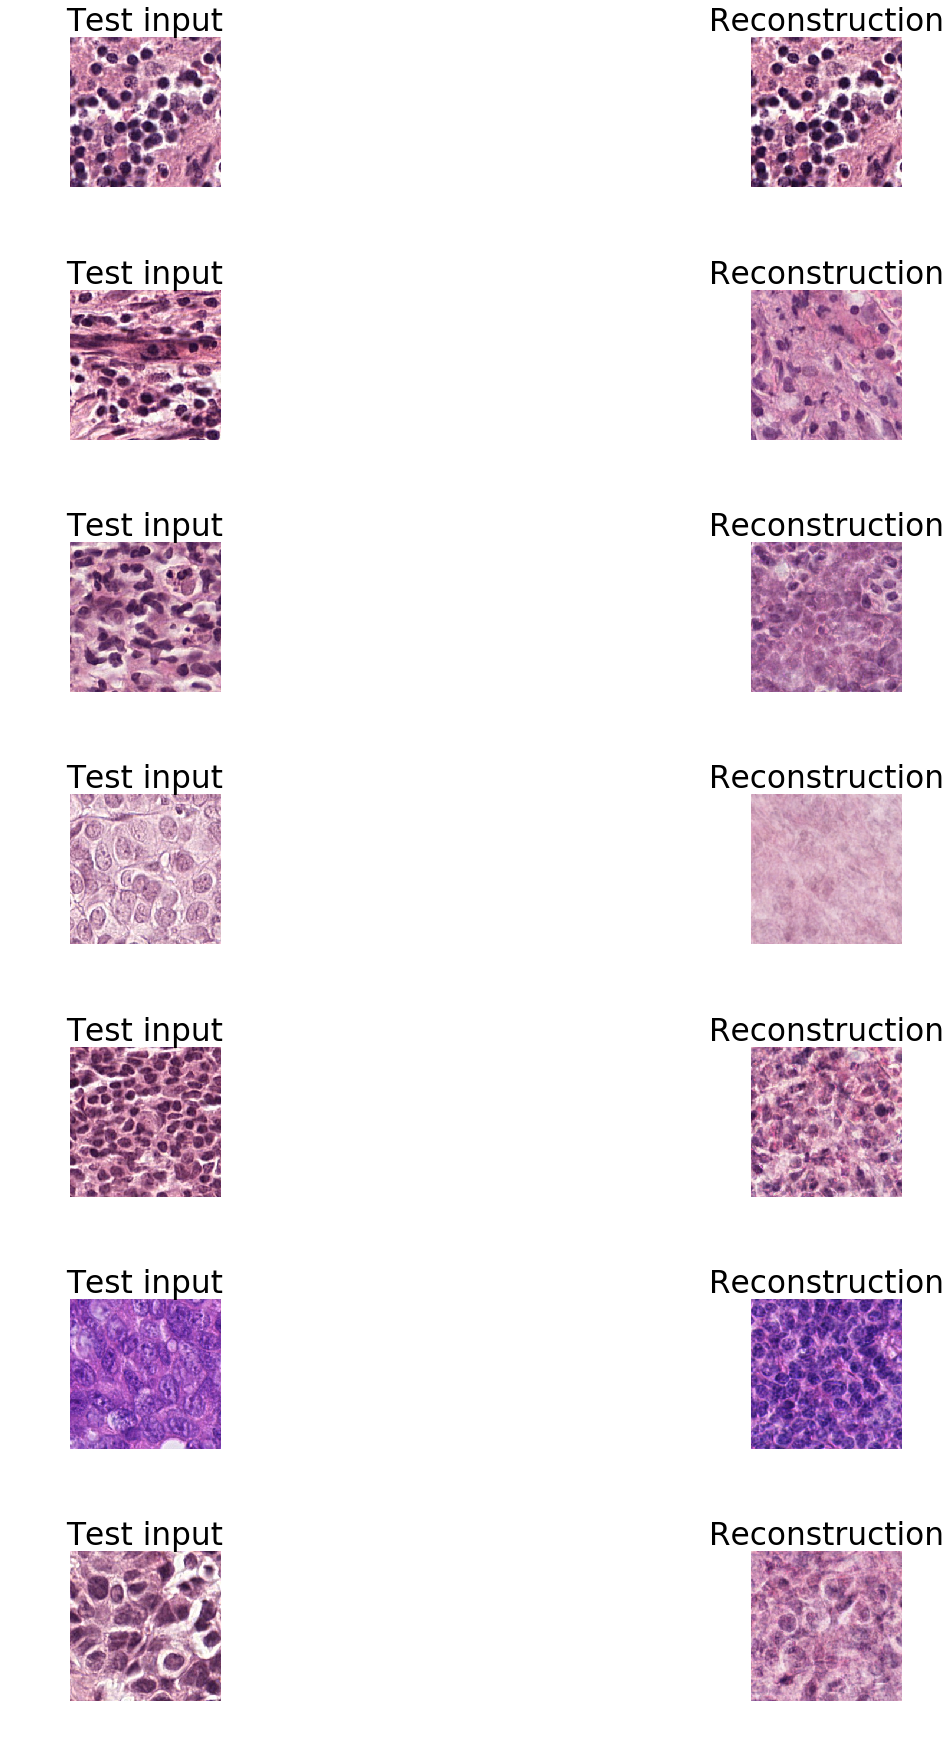

In [22]:
fig = plt.figure(figsize=(25, 25))
for i in range(7):

    ax = plt.subplot(7, 2, 2*i + 1)
    ax.imshow(x_sample[i].reshape(256, 256, 3))
    ax.set_title("Test input")
    ax.axis('off')
    #plt.colorbar()
    ax = plt.subplot(7, 2, 2*i + 2)
    ax.imshow(x_reconstruct[0][i].reshape(256, 256, 3))
    ax.set_title("Reconstruction")
    ax.axis('off')
    #plt.colorbar()
fig.tight_layout()
fig.savefig('presentation_images/autoencoder_200k_reconstruction.pdf')

In [24]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

X_train, X_valid, y_train, y_valid = train_test_split(x_encoded[0], y,
                                                    train_size=0.75, test_size=0.25)

In [26]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

Start training...
[1]	valid_0's auc: 0.673318	valid_0's l2: 0.246816
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.682499	valid_0's l2: 0.244203
[3]	valid_0's auc: 0.688176	valid_0's l2: 0.241677
[4]	valid_0's auc: 0.693304	valid_0's l2: 0.239184
[5]	valid_0's auc: 0.692947	valid_0's l2: 0.237207
[6]	valid_0's auc: 0.696847	valid_0's l2: 0.235265
[7]	valid_0's auc: 0.698129	valid_0's l2: 0.233608
[8]	valid_0's auc: 0.699047	valid_0's l2: 0.231936
[9]	valid_0's auc: 0.701619	valid_0's l2: 0.230327
[10]	valid_0's auc: 0.702283	valid_0's l2: 0.22904
[11]	valid_0's auc: 0.705212	valid_0's l2: 0.227528
[12]	valid_0's auc: 0.707151	valid_0's l2: 0.226238
[13]	valid_0's auc: 0.706216	valid_0's l2: 0.225453
[14]	valid_0's auc: 0.707493	valid_0's l2: 0.224432
[15]	valid_0's auc: 0.708173	valid_0's l2: 0.223504
[16]	valid_0's auc: 0.708832	valid_0's l2: 0.222611
[17]	valid_0's auc: 0.709991	valid_0's l2: 0.221693
[18]	valid_0's auc: 0.710665	valid_0's l2: 0.22

In [28]:
y_pred_test_gbm = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
print('The rmse of prediction is:', mean_squared_error(y_valid, y_pred_test_gbm) ** 0.5)


The rmse of prediction is: 0.46210421892043535


In [30]:
y_pred_test_gbm_bin = [1 if x>0.5 else 0 for x in y_pred_test_gbm]

In [31]:
joblib.dump(y_pred_test_gbm, '../pickles/autoencoder_2k_gbm_y_valid_prob.joblib.pickle')
joblib.dump(y_valid, '../pickles/autoencoder_2k_gbm_y_valid_label.joblib.pickle')
joblib.dump(y_pred_test_gbm_bin, '../pickles/autoencoder_2k_gbm_y_valid_pred.joblib.pickle')



['../pickles/autoencoder_2k_gbm_y_valid_pred.joblib.pickle']

# Make the tumor cells look like normal cells?

In [33]:
tumor_idx = np.where(y==1)
normal_idx = np.where(y==0)

In [56]:

tumor_samples_encoded_mean = np.mean(x_encoded[0][tumor_idx], axis=0) 
tumor_samples_encoded_std = np.std(x_encoded[0][tumor_idx], axis=0) 
normal_samples_encoded_mean = np.mean(x_encoded[0][normal_idx], axis=0) 
normal_samples_encoded_std = np.std(x_encoded[0][normal_idx], axis=0) 


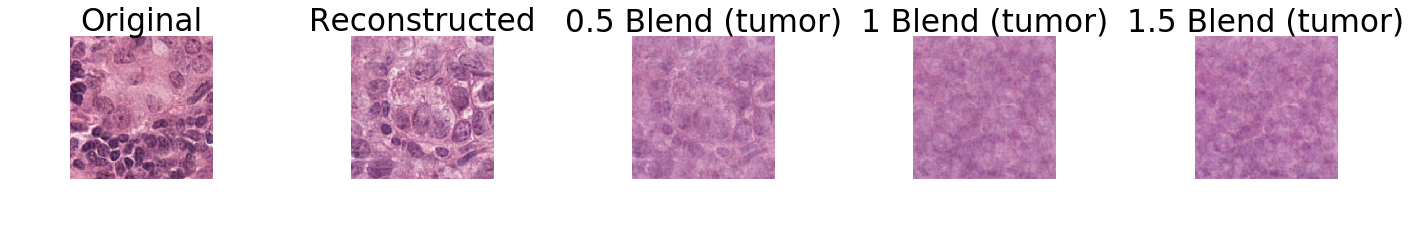

In [74]:
index = 5001
normal_sample =  x_sample[index].reshape(256, 256, 3)
normal_sample_encoded =  x_encoded[0][index]
normal_sample_encoded_normalized = (normal_sample_encoded-normal_samples_encoded_mean)/normal_samples_encoded_std

blend = normal_sample_encoded_normalized*tumor_samples_encoded_std + .5*tumor_sample_encoded_mean
reconstruct1 = model.decoder([blend])[0]

blend = normal_sample_encoded_normalized*tumor_samples_encoded_std + tumor_sample_encoded_mean
reconstruct2 = model.decoder([blend])[0]

blend = normal_sample_encoded_normalized*tumor_samples_encoded_std + 1.5*tumor_sample_encoded_mean
reconstruct3 = model.decoder([blend])[0]
 
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(151)
ax.imshow(normal_sample)
ax.axis('off')
ax.set_title('Original')
ax = plt.subplot(152)
ax.imshow(x_reconstruct[0][index].reshape(256, 256, 3))
ax.axis('off')
ax.set_title('Reconstructed')
ax = plt.subplot(153)
ax.imshow(reconstruct1.reshape(256, 256, 3))
ax.axis('off')
ax.set_title('0.5 Blend (tumor)')
ax = plt.subplot(154)
ax.imshow(reconstruct2.reshape(256, 256, 3))
ax.axis('off')
ax.set_title('1 Blend (tumor)')
ax = plt.subplot(155)
ax.imshow(reconstruct3.reshape(256, 256, 3))
ax.axis('off')
ax.set_title('1.5 Blend (tumor)')
fig.tight_layout()
fig.savefig('presentation_images/autoencoder_blend_tumor0.pdf')